# Solving UofT routing problem using ACO

In [1]:
import osmnx
from optalgotools.structures import Node
from optalgotools.routing import (cost, draw_route, get_child, randomized_search)
import random
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### University of Toronto search space

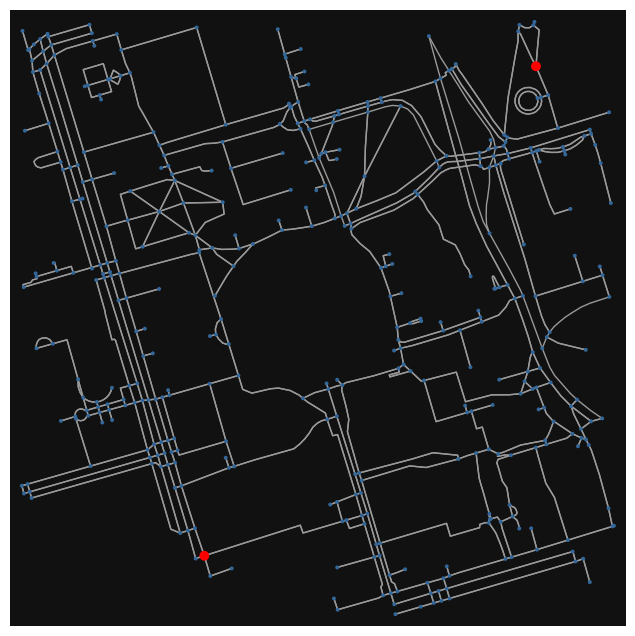

In [3]:
reference = (43.661667, -79.395)

G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)

origin = Node(graph=G, osmid=55808290)
destination = Node(graph=G, osmid=389677909)

highlighted = [389677909, 55808290]

# marking both the source and destination node
nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

### ACO algorithm

The Ant Colony algorithm will follow these steps:
1. We generate $n$ number of ants to fill our population, and place them all at the origin point (the colony).
2. We initialize the pheromone concentrations to random values, to seed the graph.
3. For each ant, the following procedures are followed:
    - The ant examines all the edges leading to neighbouring nodes, and probabilistically chooses an edge to travel based on pheromone levels. If one of the neighbouring nodes is the destination (the food source), the ant overrides this probability and goes straight for the destination.
    - If the ant is stuck, it retraces its steps back to a previous node with unexplored neighbours.
    - The ant now retraces its route, and deposits pheromone on the route, weighted inversely to the edge length.
    - If the route is a newly discovered route, we add it to our list of all known routes.
4. The route that is most frequented by the ants is selected as the "best" solution.

In [4]:
# Initialize the parameter

# Alpha and Beta are used in the pheremone calculation
alpha = 2
beta = 2

n = 500
Q = 1 # factor for post-route pheremone increase

pheremone_concentrations = dict()
known_routes = dict()

# randomize the pheromones
pheremone_concentrations = {(u,v):random.uniform(0,0.5) for [u,v] in G.edges()}

In [5]:
# a function to calculate pheremone levels
def pheremone(level, distance, alpha, beta):
    return level ** alpha * ((1/distance)) ** beta

In [6]:
for ant in tqdm(range(n)):
    # Place the ant at the colony
    frontier = [origin]
    explored = set()
    route = []
    found = False

    while frontier and not found:
        parent = frontier.pop(0)
        explored.add(parent)

        children = []
        children_pheremones = []
        for child in parent.expand():
            # If we see the destination, ignore all pheremones
            if child == destination:
                found = True
                route = child.path()
                continue
            if child not in explored:
                children.append(child)
                children_pheremones.append(
                    pheremone(
                        pheremone_concentrations[(parent.osmid, child.osmid)],
                        child.distance,
                        alpha,
                        beta,
                    )
                )

        if len(children) == 0:
            continue  # The ant is stuck, go back.

        transition_probability = [
            children_pheremones[i] / sum(children_pheremones)
            for i in range(len(children_pheremones))
        ]

        # Probabilistically choose a child to explore based weighted by transition probability
        chosen = random.choices(children, weights=transition_probability, k=1)[0]

        # Add all the non-explored children in case we need to explore them later
        children.pop(children.index(chosen))
        frontier.extend(children)

        # Set the chosen child to be the next node to explore
        frontier.insert(0, chosen)
    
    # We now have a completed route, we can increase pheremone levels 
    # on that route for the next ant to detect.

    for u, v in zip(route[:-1], route[1:]):
        length_of_edge = G[u][v][0]['length']
        pheremone_concentrations[(u,v)] += Q/length_of_edge
    
    # If the route is newly discovered, add it to the list
    route = tuple(route)
    if route in known_routes:
        known_routes[route] += 1
    else:
        known_routes[route] = 1

  0%|          | 0/500 [00:00<?, ?it/s]

### Print the best route and its cost and visualize this route

In [7]:
best_route = max(known_routes, key=known_routes.get)
times_used = known_routes[best_route]

route = list(best_route)
print("Cost:", cost(G,route))
print("Times used:",times_used)
draw_route(G,route)

Cost: 1034.626
Times used: 281


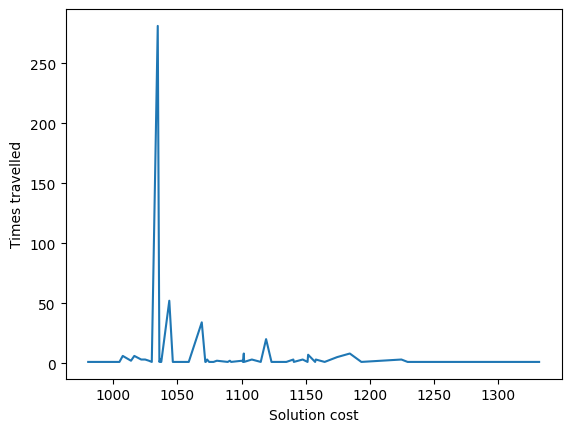

In [8]:
costs = [cost(G,r) for r in known_routes]
used = list(known_routes.values())

costs, used = zip(*sorted(zip(costs,used)))

plt.plot(costs, used)
plt.xlabel('Solution cost')
plt.ylabel('Times travelled')
plt.show()

As we can see, the most travelled route has a lower cost, as the pheremones from that route are reinforced by each subsequent ant.